## 1. Imports

In [1]:
import os
import pandas as pd
import numpy as np
from food_optimizer import FoodOptimizer
from recreation_optimizer import RecreationOptimizer
from route_optimizer import SingleSourceRouteOptimizer

## 2. Input Data

In [2]:
num_days = 3
num_people = 2
food_budget = 300
recreation_budget = 300
cur_loc_x = 40
cur_loc_y = 70

In [3]:
# Read data
DATA_PATH = "_data"
recreation = pd.read_csv(os.path.join(DATA_PATH, "recreation.csv"))
food = pd.read_csv(os.path.join(DATA_PATH, "food.csv"))


# CONSTANTS
MAX_TIME_SPENT_IN_RESTAURANT = 1.5
COST_PER_MILE = 0.3  # for gas, etc

In [4]:
recreation.head(5)

,name,rating,num_reviewer,cost,location_x,location_y,time_spent
0,Universal Studio,4.9,2000,100,75,4,9
1,Griffith Park,4.5,1230,0,46,20,1
2,Disneyland,5.0,10000,100,75,9,9
3,Hollywood,3.8,580,0,13,3,3
4,The Getty Center,4.2,1000,20,53,39,2


In [5]:
food.head(5)

,name,cost_per_person,rating,num_reviewer,location_x,location_y
0,tsujita,16,4.2,2613,83,4
1,tatsu,38,4.5,2000,51,70
2,kazunori,38,4.9,1004,2,12
3,kura,28,4.0,851,7,14
4,chincinkurin,34,4.1,1033,17,34


## 3. Data Preparation

In [6]:
# Get satisfaction column by multiplying rating with the log of number of reviews
# this metric is subject to change
recreation["satisfaction"] = recreation["rating"] * np.log(recreation["num_reviewer"])
food["satisfaction"] = food["rating"] * np.log(food["num_reviewer"])

# Sanity check
assert "satisfaction" in recreation.columns
assert "satisfaction" in food.columns

## 4. Run Solver for Sub-Problems

In [7]:
# Instantiate optimizer with given parameters
food_opt = FoodOptimizer(food, num_days, num_people, food_budget)
rec_opt = RecreationOptimizer(recreation, num_days, recreation_budget)

# Run the optimizer
food_model = food_opt.SolveUsingPyomo()
rec_model = rec_opt.SolveUsingPyomo()

# Grab the results
food_selected = food_opt.filter_selected()
rec_selected = rec_opt.filter_selected()


Optimizing restaurant satisfaction...
	Building Pyomo model...
	Creating indices and set...
	Creating variables...
	Creating parameters...
	Creating objective function...
	Creating constraint on available budget...
	Creating constraint on requirement to eat exactly twice a day...
	Done.
	Running solver...
Done optimizing restaurant choices.

Optimizing restaurant satisfaction...
	Building Pyomo model...
	Creating indices and set...
	Creating variables...
	Creating parameters...
	Creating objective function...
	Creating constraint on available budget...
	Creating constraint on available time...
	Creating constraint on three places a day...
	Done.
	Running solver...
Done optimizing recreational spot choices.

Restaurants:
 - tsujita (selected)
 - tatsu 
 - kazunori 
 - kura 
 - chincinkurin 
 - howlin rays (selected)
 - catch LA 
 - coco curry (selected)
 - red rock (selected)
 - feast 
 - gushi 
 - chipotle 
 - chick-fill-a 
 - northern cafe 
 - panda express 
 - boiling point 
 - kang

### View Results


The result is two data frames with filtered rows

In [8]:
food_selected

,name,cost_per_person,rating,num_reviewer,location_x,location_y,satisfaction
0,tsujita,16,4.2,2613,83,4,33.046668
1,howlin rays,17,4.4,2729,71,29,34.811438
2,coco curry,25,4.9,1351,77,48,35.322142
3,red rock,28,4.9,1373,7,99,35.401292
4,marugame udon,27,4.4,2793,71,47,34.913435
5,daikokuya,21,4.8,1574,15,61,35.334602


In [9]:
rec_selected

,name,rating,num_reviewer,cost,location_x,location_y,time_spent,satisfaction
0,Universal Studio,4.9,2000,100,75,4,9,37.244422
1,Griffith Park,4.5,1230,0,46,20,1,32.016463
2,Disneyland,5.0,10000,100,75,9,9,46.051702
3,The Broad,4.2,1500,0,91,79,1,30.715526
4,Lacma,4.6,1800,30,31,46,2,34.479493
5,Rodeo Drive,4.5,6000,0,80,22,5,39.147816


## 5. Preprocess Sub-Problems Result

In [10]:
# Subset the necessary column 
food_selected = food_selected.loc[:,["name", "location_x", "location_y"]]
rec_selected = rec_selected.loc[:,["name", "location_x", "location_y", "time_spent"]]
food_selected["time_spent"] = MAX_TIME_SPENT_IN_RESTAURANT 
food_selected["is_restaurant"] = 1
rec_selected["is_restaurant"] = 0

In [11]:
# Concate the dataframe into one
spots = pd.concat([pd.DataFrame({'name': ['current location'],
                                 'location_x': [cur_loc_x],
                                 'location_y': [cur_loc_y],
                                 'time_spent': [0],
                                 'is_restaurant': [0]}),
                   food_selected,
                   rec_selected], ignore_index=True)

In [12]:
spots

,name,location_x,location_y,time_spent,is_restaurant
0,current location,40,70,0.0,0
1,tsujita,83,4,1.5,1
2,howlin rays,71,29,1.5,1
3,coco curry,77,48,1.5,1
4,red rock,7,99,1.5,1
5,marugame udon,71,47,1.5,1
6,daikokuya,15,61,1.5,1
7,Universal Studio,75,4,9.0,0
8,Griffith Park,46,20,1.0,0
9,Disneyland,75,9,9.0,0


## 6. Solve the Routing Problem (Master)

In [13]:
# Instantiate optimizer with given parameters
route_optimizer = SingleSourceRouteOptimizer(
    (cur_loc_x, cur_loc_y), food_selected, rec_selected, num_days, COST_PER_MILE
)

X, mdl, sol = route_optimizer.SolveUsingDocplex()


Optimizing route...
Done


### View Results

In [14]:
# Get list of routes
routes = route_optimizer.get_routes()
route_dist = route_optimizer.get_total_distance()
route_cost = route_optimizer.get_total_cost()
print(routes)

[[[0, 2], [2, 9], [9, 5], [5, 0]], [[0, 4], [4, 7], [7, 1], [1, 0]], [[0, 10], [10, 3], [3, 12], [12, 8], [8, 11], [11, 6], [6, 0]]]


In [15]:
################
# Route Result #
################
print()
print("*******************************************************")
print("*******************************************************")
print("\n\n")
print("Schedule:")
for i in range(len(routes)):
    print()
    print(f"Day {i+1}")
    for route in routes[i]:
        if route[1] != 0:
            print(f" * {spots.loc[route[1], 'name'].capitalize()}")
    print(f"Total day {i+1} distance: {round(route_dist[i], 3)}")
    print(f"Estimated cost: {round(route_cost[i], 3)}")


*******************************************************
*******************************************************



Schedule:

Day 1
 * Howlin rays
 * Disneyland
 * Marugame udon
Total day 1 distance: 148.607
Estimated cost: 44.582

Day 2
 * Red rock
 * Universal studio
 * Tsujita
Total day 2 distance: 247.533
Estimated cost: 74.26

Day 3
 * The broad
 * Coco curry
 * Rodeo drive
 * Griffith park
 * Lacma
 * Daikokuya
Total day 3 distance: 224.553
Estimated cost: 67.366


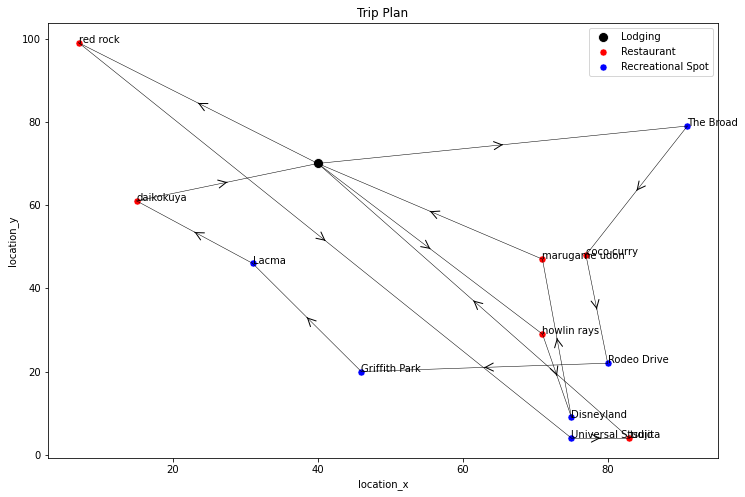

In [16]:
route_optimizer.plot_map(size=(12, 8))